In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [12]:
import pandas as pd
import random
import os
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [14]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,TRAIN_0000,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,TRAIN_0001,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,TRAIN_0002,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN_0003,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,TRAIN_0004,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
test.head()

,PRODUCT_ID,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,TEST_000,T100304,T_31,2.0,94.0,0.0,45.0,11.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,T100306,T_31,3.0,89.0,0.0,45.0,10.0,0.0,51.0,...,0.000007,0.000004,0.189134,0.000032,0.000664,0.000041,0.000004,0.000003,0.187,0.00003
2,TEST_002,T100304,T_31,2.0,100.0,0.0,45.0,10.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
train = train.drop(['PRODUCT_ID'], axis = 1)
test = test.drop(['PRODUCT_ID'], axis = 1)

# regression range

In [17]:
min(train[train['Y_Class']==2]['Y_Quality'])

0.534950794

In [18]:
max(train[train['Y_Class']==1]['Y_Quality'])

0.534842857

In [19]:
min(train[train['Y_Class']==1]['Y_Quality'])

0.525085714

In [20]:
max(train[train['Y_Class']==0]['Y_Quality'])

0.525066667

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train['LINE'])
train['LINE'] = le.transform(train['LINE'])
test['LINE'] = le.transform(test['LINE'])

le.fit(train['PRODUCT_CODE'])
train['PRODUCT_CODE'] = le.transform(train['PRODUCT_CODE'])
test['PRODUCT_CODE'] = le.transform(test['PRODUCT_CODE'])

In [40]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor
from sklearn.metrics import f1_score

score = []
result_list = []
    
for z in range(3):
    skf = StratifiedKFold(n_splits = 10, random_state = 42*z, shuffle = True) #총 30번의 fold 진행

    train_x = train.drop(["Y_Class", "Y_Quality"], axis = 1)
    train_y = train["Y_Class"]

    n = 0

    for train_index, valid_index in skf.split(train_x, train_y): #label 기준으로 stratified k fold 진행

        train_X = np.array(train.drop(["Y_Class", "Y_Quality"], axis = 1))
        train_Y = np.array(train["Y_Quality"])
        real_Y = np.array(train["Y_Class"])

        test_X = np.array(test)

        X_train, X_valid = train_X[train_index], train_X[valid_index]
        y_train, y_valid = train_Y[train_index], train_Y[valid_index]
        _, y_real = real_Y[train_index], real_Y[valid_index]

        X_train = X_train
        X_valid = X_valid
        X_test = test_X

        param = {
            'task_type':"GPU",
            'random_seed':42,
            'verbose':0,
            'learning_rate': 0.1,
        }

        model_cat = CatBoostRegressor(**param)

        model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=200)
        preds_1 = model_cat.predict(X_valid)

        for i in range(len(preds_1)):
            if preds_1[i] < 0.525085714:
                preds_1[i] = 0
            elif preds_1[i] > 0.534842857:
                preds_1[i] = 2
            else:
                preds_1[i] = 1
        preds_1 = preds_1.astype(int)

        print("point", z, "fold", n, "score", f1_score(y_real, preds_1, average='macro'))
        score.append(f1_score(y_real, preds_1, average='macro'))
        result_list.append(model_cat.predict(X_test))
        n += 1

print("final_score", sum(score)/30)

point 0 fold 0 score 0.6113733609385784
point 0 fold 1 score 0.6627549509248194
point 0 fold 2 score 0.657059235223007
point 0 fold 3 score 0.6534883720930232
point 0 fold 4 score 0.6526610644257702
point 0 fold 5 score 0.6840495547812621
point 0 fold 6 score 0.648015873015873
point 0 fold 7 score 0.7834169920059492
point 0 fold 8 score 0.6983401084010841
point 0 fold 9 score 0.6956234672703264
point 1 fold 0 score 0.6054586563307494
point 1 fold 1 score 0.5777579010137149
point 1 fold 2 score 0.5696382428940568
point 1 fold 3 score 0.7544477028347996
point 1 fold 4 score 0.8123489076959709
point 1 fold 5 score 0.6396178984414278
point 1 fold 6 score 0.6233100672829026
point 1 fold 7 score 0.6753246753246752
point 1 fold 8 score 0.604015525955712
point 1 fold 9 score 0.6949272949272949
point 2 fold 0 score 0.7061989292758524
point 2 fold 1 score 0.6163606508434095
point 2 fold 2 score 0.6985655728170698
point 2 fold 3 score 0.5915375645510578
point 2 fold 4 score 0.6262626262626262
poi

In [41]:
result = np.array(result_list[0])

for i in range(1, len(result_list)):
    result += result_list[i]

result /= 30

for i in range(len(result)):
    if result[i] < 0.525085714:
        result[i] = 0
    elif result[i] > 0.534842857:
        result[i] = 2
    else:
        result[i] = 1
        
reg_pred = result.astype(int)

print(len(reg_pred))

535


In [42]:
import warnings
warnings.filterwarnings("ignore")

# LOAD NPARR

In [94]:
np_arr = np.load('./numpy_selected_feature_5fold_original_300.npy')
np_arr = np.concatenate(np_arr)

np_arr = list(set(np_arr))

In [95]:
np_arr.append(0)

np_arr.sort()
np_arr

[0,
 1,
 5,
 9,
 18,
 21,
 22,
 39,
 42,
 45,
 46,
 54,
 56,
 57,
 61,
 62,
 63,
 64,
 66,
 74,
 91,
 102,
 108,
 112,
 115,
 121,
 122,
 124,
 125,
 126,
 127,
 128,
 131,
 132,
 137,
 138,
 141,
 150,
 190,
 241,
 243,
 244,
 249,
 257,
 258,
 259,
 266,
 267,
 268,
 274,
 286,
 293,
 295,
 304,
 308,
 319,
 339,
 340,
 346,
 355,
 368,
 369,
 373,
 374,
 375,
 381,
 388,
 390,
 396,
 400,
 402,
 403,
 406,
 409,
 424,
 429,
 441,
 445,
 450,
 453,
 455,
 456,
 457,
 459,
 463,
 474,
 475,
 477,
 484,
 486,
 487,
 494,
 496,
 503,
 516,
 517,
 518,
 522,
 523,
 525,
 531,
 532,
 533,
 534,
 539,
 543,
 545,
 547,
 548,
 550,
 557,
 573,
 577,
 595,
 596,
 605,
 614,
 623,
 644,
 659,
 660,
 661,
 662,
 664,
 665,
 668,
 669,
 675,
 683,
 686,
 698,
 699,
 701,
 712,
 714,
 717,
 721,
 726,
 742,
 767,
 770,
 771,
 774,
 776,
 791,
 814,
 824,
 826,
 836,
 838,
 841,
 843,
 848,
 854,
 856,
 859,
 870,
 871,
 874,
 883,
 894,
 902,
 904,
 905,
 909,
 910,
 912,
 924,
 926,
 932,
 933,

In [96]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import lightgbm

train_x = train.drop(["Y_Class", "Y_Quality"], axis = 1)
train_y = train["Y_Class"]
score = []
result_list = []
    
for z in range(3):
    skf = StratifiedKFold(n_splits = 10, random_state = 422**z, shuffle = True) #총 30번의 fold 진행


    n = 0

    for train_index, valid_index in skf.split(train_x, train_y): #label 기준으로 stratified k fold 진행

        train_X = np.array(train_x)
        train_Y = np.array(train_y)
        test_X = np.array(test)

        X_train, X_valid = train_X[train_index], train_X[valid_index]
        y_train, y_valid = train_Y[train_index], train_Y[valid_index]

        X_train = X_train[:, np_arr]
        X_valid = X_valid[:, np_arr]
        X_test = test_X[:, np_arr]

        sum_pred = []

        ### CAT
        model_cat = CatBoostClassifier(iterations=1000,
                                       random_seed=422,
                                       learning_rate=0.1,
                                       max_depth=5,
                                       grow_policy="Depthwise",
                                       verbose=0,
                                       task_type="GPU")

        model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=200)
        preds_1 = model_cat.predict(X_valid)
        preds_proba_1 = model_cat.predict_proba(X_valid)
        result_list.append(model_cat.predict_proba(X_test))
        print("score", f1_score(y_valid, preds_1, average='macro'))

        ### XGB
        best_param = {'random_state': 422, 
                      'lambda': 0.07, 
                      'alpha': 0.25, 
                      'colsample_bytree': 0.82, 
                      'subsample': 0.82, 
                      'learning_rate': 0.06, 
                      'n_estimators': 101, 
                      'max_depth': 10, 
                      'min_child_weight': 4}

        model = XGBClassifier(**best_param)

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=200, verbose=False)
        preds_2 = model.predict(X_valid)
        preds_proba_2 = model.predict_proba(X_valid)
        result_list.append(model.predict_proba(X_test))
        print("score", f1_score(y_valid, preds_2, average='macro'))

        ### LGB
        lgb_param = {'random_state': 422, 
                     'learning_rate': 0.09, 
                     'n_estimators': 301, 
                     'max_depth': 13, 
                     'min_child_samples': 10, 
                     'subsample': 0.91}

        model_lgbm = LGBMClassifier(**lgb_param)
        fit_params = dict(
            eval_set=[(X_valid, y_valid)],
            )

        model_lgbm.fit(X_train, 
                       y_train, 
                       **fit_params, 
                       callbacks = [lightgbm.log_evaluation(period=1000, show_stdv=True),
                                   #lightgbm.early_stopping(stopping_rounds=300)
                                   ])
        preds_3 = model_lgbm.predict(X_valid)
        preds_proba_3 = model_lgbm.predict_proba(X_valid)
        result_list.append(model_lgbm.predict_proba(X_test))
        print("score", f1_score(y_valid, preds_3, average='macro'))

        ### SUM
        result = preds_proba_1 + preds_proba_2 + preds_proba_3
        pred = np.argmax(result, axis = 1)
        print(z, "fold", n, "score", f1_score(y_valid, pred, average='macro'))
        score.append(f1_score(y_valid, pred, average='macro'))
        n += 1

print("final_score", sum(score)/30)

score 0.5978467908902693
score 0.5992865159531826
score 0.6161479250334673
0 fold 0 score 0.6203264466737521
score 0.6137474879317132
score 0.6759509303832422
score 0.6664750957854406
0 fold 1 score 0.6448521692424132
score 0.7189599766286884
score 0.7436107053352453
score 0.6826434277414669
0 fold 2 score 0.7063664972161705
score 0.684586731098359
score 0.6721180054513387
score 0.7122154471544716
0 fold 3 score 0.7122154471544716
score 0.7809099113446939
score 0.7294796157071605
score 0.7800499886389457
0 fold 4 score 0.7611354318671392
score 0.740302432610125
score 0.6905898072151174
score 0.7494674185463658
0 fold 5 score 0.7476967476967477
score 0.7222324763788178
score 0.7373739950427067
score 0.7410037391513157
0 fold 6 score 0.7259615384615384
score 0.618860877684407
score 0.6425783726664318
score 0.6433695429391268
0 fold 7 score 0.6732370553011623
score 0.6809738955823293
score 0.6615471898718345
score 0.6784222468339992
0 fold 8 score 0.7007936507936509
score 0.71166630140989

In [97]:
result = np.array(result_list[0])

for i in range(1, len(result_list)):
    result += result_list[i]

cls_data = np.argmax(result, axis = 1)

In [98]:
len(reg_pred)

535

In [99]:
len(cls_data)

535

In [100]:
real_pred = []

for i in range(len(reg_pred)):
    if reg_pred[i] == cls_data[i]:
        real_pred.append(reg_pred[i])
        
    else:
        if reg_pred[i] == 1:
            real_pred.append(cls_data[i])
        
        elif cls_data[i] == 1:
            real_pred.append(reg_pred[i])
            
        else:
            real_pred.append(reg_pred[i])

In [101]:
filename = './dataset/sample_submission.csv'
sample_submission = pd.read_csv(filename)
sample_submission.head()
sample_submission["Y_Class"] = real_pred
sample_submission.to_csv('./reg_and_cls_kang_422.csv', index=False)

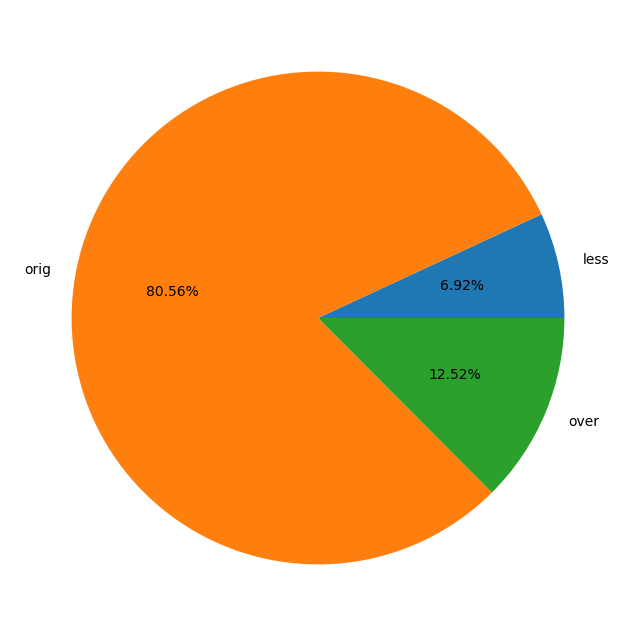

In [53]:
result = [0, 0, 0]

for i in range(reg_pred.shape[0]):
    if reg_pred[i] == 0:
        result[0] += 1
    elif reg_pred[i] == 1:
        result[1] += 1
    else:
        result[2] += 1 
            

labels = ["less","orig","over"]

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 하얀색
 
ax = fig.add_subplot() ## 프레임 생성
 
ax.pie(x=result,labels=labels,autopct=lambda p : '{:.2f}%'.format(p)) ## 파이 차트 출력
plt.show()

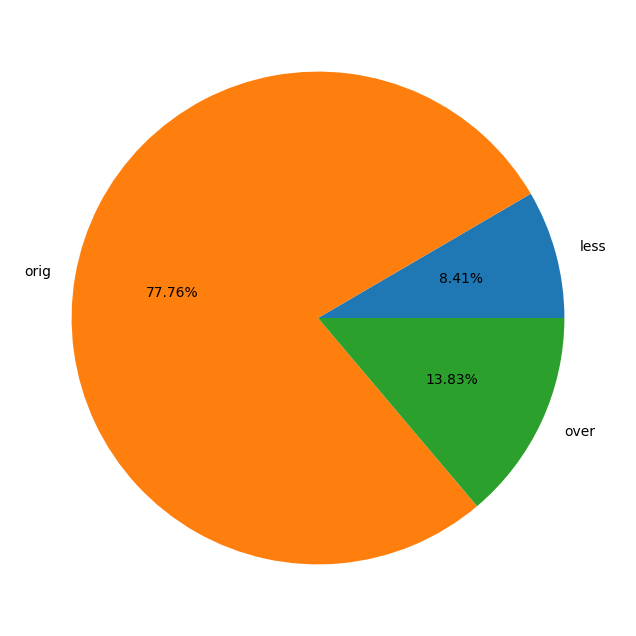

In [54]:
result = [0, 0, 0]

for i in range(cls_data.shape[0]):
    if cls_data[i] == 0:
        result[0] += 1
    elif cls_data[i] == 1:
        result[1] += 1
    else:
        result[2] += 1 
            

labels = ["less","orig","over"]

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 하얀색
 
ax = fig.add_subplot() ## 프레임 생성
 
ax.pie(x=result,labels=labels,autopct=lambda p : '{:.2f}%'.format(p)) ## 파이 차트 출력
plt.show()

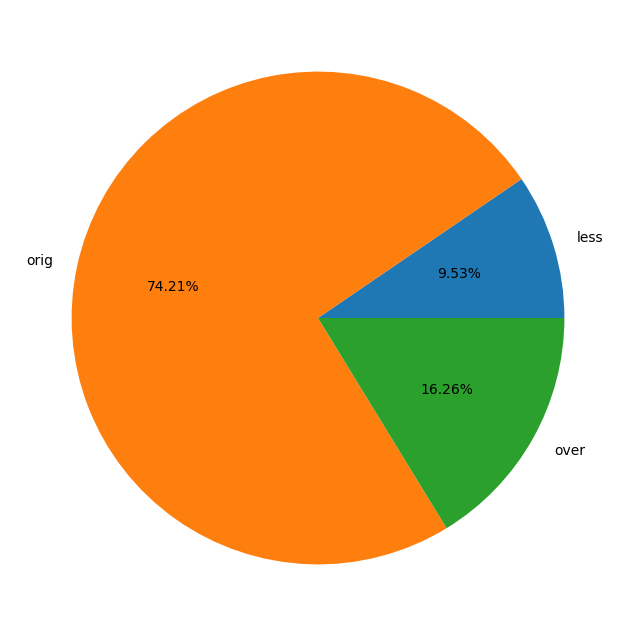

In [55]:
result = [0, 0, 0]

for i in range(len(real_pred)):
    if real_pred[i] == 0:
        result[0] += 1
    elif real_pred[i] == 1:
        result[1] += 1
    else:
        result[2] += 1 
            

labels = ["less","orig","over"]

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 하얀색
 
ax = fig.add_subplot() ## 프레임 생성
 
ax.pie(x=result,labels=labels,autopct=lambda p : '{:.2f}%'.format(p)) ## 파이 차트 출력
plt.show()